# Time Series Analysis with Prophet model
## Import libraries

In [1]:
import pandas as pd
import numpy as np

# modeling
from prophet import Prophet

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.io as pio
pio.renderers.default = "notebook"
sns.axes_style("darkgrid")
sns.set_theme()

# evaluating
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import performance_metrics

# showing
from IPython.display import display

# model saving/loading
from prophet.serialize import model_from_json, model_to_json
import json
import datetime
import time

import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

import mlflow
#from mlflow import prophet

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

import warnings
warnings.filterwarnings('ignore')

from prophet.serialize import model_from_json

## Data

In [2]:
# import train data and format timestamp column
df = pd.read_csv('../data/cleaned_sensors_dwd_train.csv', index_col=0)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# import test data and format timestamp column
df_test_data = pd.read_csv('../data/cleaned_sensors_dwd_test.csv', index_col=0)
df_test_data['timestamp'] = pd.to_datetime(df_test_data['timestamp'])

## Choose location and set prediction time

In [3]:
# choose locations (all or several)
#location_list_reg = df['location_id'].unique().tolist()
# several: six locations chosen for hyperparameter tuning
location_list_reg = [133, 159, 129, 14, 119, 52]
#location_list_reg = [119, 52]

prediction_time = 7 * 24    # days * hours

NUMBER_OF_MODELS_REG = len(location_list_reg)

# Prophet with regressors
## Prepare Data

In [4]:
# prepare DataFrame for prophet with column names as expected
# regressors
df_prophet_reg = df[['timestamp','PM2p5','location_id', 'humidity_dwd', 'temperature_dwd', 'pressure_dwd', 'wind_speed', 'precip', 'wind_direction', 'city']]  
df_prophet_reg.rename(columns={'timestamp': 'ds', 'PM2p5': 'y', 'humidity_dwd': 'humi', 'temperature_dwd': 'temp', 'pressure_dwd': 'press', 'wind_speed': 'windsp', 'precip': 'precip', 'wind_direction': 'winddir'}, inplace=True) #

# drop nans
df_prophet_reg.dropna(subset=['humi', 'temp', 'press', 'windsp', 'precip', 'winddir'], inplace=True)

#print(df_prophet_reg.isna().sum())

## Train model and predict

In [5]:
def create_regressor_column(ds, train_col, test_col):
    """Get a regressor of train or test data for corresponding timestamp (needed for creation of future_dataframe)

    Args:
        ds (datetime): timestamp
        train_col (string): column name of regressor in train data
        test_col (string): column name of regressor in test data

    Returns:
        float: regressor value for given timestamp
    """
    
    if ds in df_prophet_reg['ds'].values:
        return df_prophet_reg[df_prophet_reg['ds'] == ds][train_col].values[0]
    elif ds in df_test_data['timestamp'].values:
        return df_test_data[df_test_data['timestamp'] == ds][test_col].values[0]
    else:
        return np.nan
        

In [6]:
def time_convert(sec):
    mins = sec // 60
    sec = sec % 60
    hours = mins // 60
    mins = mins % 60

    sec_str = ('0' + str(int(sec)))[-2:]
    mins_str = ('0' + str(int(mins)))[-2:]
    hours_str = ('0' + str(int(hours)))[-2:]  
    #print("Time Lapsed = {0}:{1}:{2}".format(int(hours),int(mins),sec))
    return hours_str + ':' + mins_str + ':' + sec_str

In [7]:
# set hyperparameters
# Edit to try out different settings
run_name = 'without_humi_pc0p2_cpc0p1'

seasonality_mode='additive'
yearly_seasonality=True
weekly_seasonality=True
daily_seasonality=True

growth='logistic'
n_changepoints=20
changepoint_prior_scale = 0.1  #default 0.05

temp_flag = True
humi_flag = False
press_flag = True
windsp_flag = True
winddir_flag = True
precip_flag = True

temp_prior_scale = 0.20
humi_prior_scale = 0.20
press_prior_scale = 0.20
windsp_prior_scale = 0.20
winddir_prior_scale = 0.20
precip_prior_scale = 0.20

if not temp_flag:
    temp_prior_scale = None
if not humi_flag:
    humi_prior_scale = None
if not press_flag:
    press_prior_scale = None
if not windsp_flag:
    windsp_prior_scale = None
if not winddir_flag:
    winddir_prior_scale = None
if not precip_flag:
    precip_prior_scale = None




## Loop over locations

In [8]:
# create dictionary to save models later
prophet_models_per_location_reg = {}

# create dictionary to save prediction results
prophet_forecasts_per_location_reg = {}

# create dictionaries for RMSE of train and test data
rmse_dict_reg_train = {}
rmse_dict_reg_test = {}

# train model for selected locations
for n, location_id in enumerate(location_list_reg[:NUMBER_OF_MODELS_REG]):
    print('-----'*10)
    print(f'no: {n + 1}, location_id: {location_id}')
    start_time = time.time()

    # limit dataframe to specific location_id
    df_location_reg = df_prophet_reg[df_prophet_reg['location_id'] == location_id]

    # calculate cap and floor for growth = logistic
    # calculate moving average of training
    df_average = df_location_reg[['location_id', 'ds', 'y']]

    
    df_average['PM2p5_average'] = df_average['y'].rolling(window=5, center=True).mean()

    # calculate cap and floor for all locations
    cap = df_average[['PM2p5_average']].quantile(0.99)[0]
    floor = df_average[['PM2p5_average']].min()[0]

    # add cap and floor for growth=logistic
    df_location_reg['cap'] = cap
    df_location_reg['floor'] = floor

    city = df_location_reg['city'].max()

    # drop columns that are not needed
    df_location_reg.drop(['location_id', 'city'], axis=1, inplace=True)

    # init Prophet model and fit it to train data for given location
    model_reg = Prophet(seasonality_mode=seasonality_mode, yearly_seasonality=yearly_seasonality, weekly_seasonality=weekly_seasonality,
                     daily_seasonality=daily_seasonality, growth=growth,n_changepoints=n_changepoints, changepoint_prior_scale=changepoint_prior_scale)
    # regressors
    if temp_flag:
        model_reg.add_regressor('temp', standardize=True, prior_scale=temp_prior_scale)
    if humi_flag:
        model_reg.add_regressor('humi', standardize=True, prior_scale=humi_prior_scale)
    if press_flag:
        model_reg.add_regressor('press', standardize=True, prior_scale=press_prior_scale)
    if windsp_flag:
        model_reg.add_regressor('windsp', standardize=True, prior_scale=windsp_prior_scale)
    if winddir_flag:
        model_reg.add_regressor('winddir', standardize=True, prior_scale=winddir_prior_scale)
    if precip_flag:
        model_reg.add_regressor('precip', standardize=True, prior_scale=precip_prior_scale)

    print(f'start training')
    model_reg.fit(df_location_reg)

    # save model in dictionary
    prophet_models_per_location_reg[location_id] = model_reg

    #------------------------------------------------
    print(f'start prediction')
    print(f'')
    # prediction
    # limit test data to current location
    df_test_location = df_test_data[df_test_data['location_id'] == location_id]

    # create dataframe for future predictions and predict
    future_reg = model_reg.make_future_dataframe(periods=prediction_time, freq='H')

    if temp_flag:
        future_reg['temp'] = future_reg['ds'].apply(create_regressor_column, args=('temp', 'temperature_dwd'))
    if humi_flag:
        future_reg['humi'] = future_reg['ds'].apply(create_regressor_column, args=('humi', 'humidity_dwd'))
    if press_flag:
        future_reg['press'] = future_reg['ds'].apply(create_regressor_column, args=('press', 'pressure_dwd'))
    if windsp_flag:
        future_reg['windsp'] = future_reg['ds'].apply(create_regressor_column, args=('windsp', 'wind_speed'))   
    if winddir_flag:
        future_reg['winddir'] = future_reg['ds'].apply(create_regressor_column, args=('winddir', 'wind_direction'))   
    if precip_flag:
        future_reg['precip'] = future_reg['ds'].apply(create_regressor_column, args=('precip', 'precip'))   

    # drop nans
    future_reg.dropna(inplace=True)
    
    # add cap and floor for growth = logistic
    future_reg['cap'] = cap
    future_reg['floor'] = floor

    # predict for given location
    forecast_reg = model_reg.predict(future_reg)

    # save predictions in dataframe
    prophet_forecasts_per_location_reg[location_id] = forecast_reg

    #---------------------------------------
    print(f'calculate rmse')
    # Calculate Metrics
    # test data
    # limit columns of test data for calculating rmse and limit timespan to predicted timespan
    df_rmse_test_reg = df_test_location.query(f"timestamp <= '{max(forecast_reg.ds)}'")[['timestamp','PM2p5']]
    if len(df_rmse_test_reg) != 0:
        # merge forecast to test data
        df_rmse_test_reg = df_rmse_test_reg.merge(forecast_reg[['yhat', 'ds']], how='left', left_on='timestamp', right_on='ds').drop(columns='ds', axis=1)
        # drop NaN        
        df_rmse_test_reg.dropna(inplace=True)
        # calculate rmse for specific time span
        rmse_test_reg = mean_squared_error(df_rmse_test_reg['PM2p5'], df_rmse_test_reg['yhat'], squared=False)

        #save result
        rmse_dict_reg_test[location_id] = rmse_test_reg
    else:
        #save empty result
        rmse_dict_reg_test[location_id] = None

    # train data
    # use complete train
    df_rmse_train_reg = df_location_reg[['ds','y']]
    # merge forecast to train data
    df_rmse_train_reg = df_rmse_train_reg.merge(forecast_reg[['yhat', 'ds']], how='left', left_on='ds', right_on='ds').drop(columns='ds', axis=1)
    # drop NaN    
    df_rmse_train_reg.dropna(inplace=True)
    # calculate rmse for specific time span
    rmse_train_reg = mean_squared_error(df_rmse_train_reg['y'], df_rmse_train_reg['yhat'], squared=False)

    #save result
    rmse_dict_reg_train[location_id] = rmse_train_reg

    # show results
    print(f'RMSE test = {None if rmse_test_reg is None else round(rmse_test_reg,2)} µg/m3')
    print(f'RMSE train = {round(rmse_train_reg,2)} µg/m3')

    end_time = time.time()
    time_lapsed = end_time - start_time
    time_converted = time_convert(time_lapsed)

    #------------------------------------------------------------
    # setting the MLFlow connection and experiment
    mlflow.set_tracking_uri(TRACKING_URI)
    mlflow.set_experiment(EXPERIMENT_NAME)
    with mlflow.start_run(run_name=run_name): 
        mlflow.log_params({'seasonality_mode': seasonality_mode, 'yearly_seasonaliy': yearly_seasonality, 'weekly_seasonality': weekly_seasonality, 'daily_seasonality': daily_seasonality,
                'growth': growth, 'n_changepoints': n_changepoints,
                'temp_prior_scale': temp_prior_scale, 'humi_prior_scale': humi_prior_scale, 'press_prior_scale': press_prior_scale, 'windsp_prior_scale': windsp_prior_scale, 'winddir_prior_scale': winddir_prior_scale, 'precip_prior_scale': precip_prior_scale,
                'temp_flag': temp_flag, 'humi_flag': humi_flag, 'press_flag': press_flag, 'windsp_flag': windsp_flag, 'winddir_flag': winddir_flag, 'precip_flag': precip_flag, 
                'cap': cap, 'floor': floor, 'changepoint_prior_scale': changepoint_prior_scale,
                'location_id': location_id
                })

        mlflow.set_tags({'location_id': location_id, 'city': city, 'runtime': time_converted})
        mlflow.log_metrics({'RMSE_train': rmse_train_reg, 'RMSE_test': rmse_test_reg})
    mlflow.end_run()


--------------------------------------------------
no: 1, location_id: 133
start training
Initial log joint probability = -13.5719
start prediction    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       68037.6     0.0317564       71127.8           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       69504.7   0.000644417       2452.96      0.7992      0.7992      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       69535.4    0.00128359       2348.16           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       69544.1    0.00608096       3386.33           1           1      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       69585.3   0.000714947       93

# Plot

In [9]:
def plot_model_with_future(model, forecast, future, file):
    # train data and predition
    fig = model.plot(forecast, xlabel='Date', ylabel='Value', figsize=(20, 6))
    ax = fig.gca()
    
    # test data
    sns.scatterplot(data=future, x='timestamp', y='PM2p5', ax=ax, color='green')
    plt.title(f'location {location_id}', fontsize=34)
    ax.set_xlabel("Date", size=34)
    ax.set_ylabel("PM 2.5 in µg/m³", size=34)
    ax.tick_params(axis="x", labelsize=24)
    ax.tick_params(axis="y", labelsize=24)
    ax.set_ylim(0, cap * 2)
    ax.set_xlim(min(df.query(f'location_id == {location_id}').timestamp), max(df.query(f'location_id == {location_id}').timestamp) + datetime.timedelta(hours=prediction_time))

    #save figure
    fig.savefig(file, bbox_inches='tight', facecolor="#EEEEEE")

    plt.show()

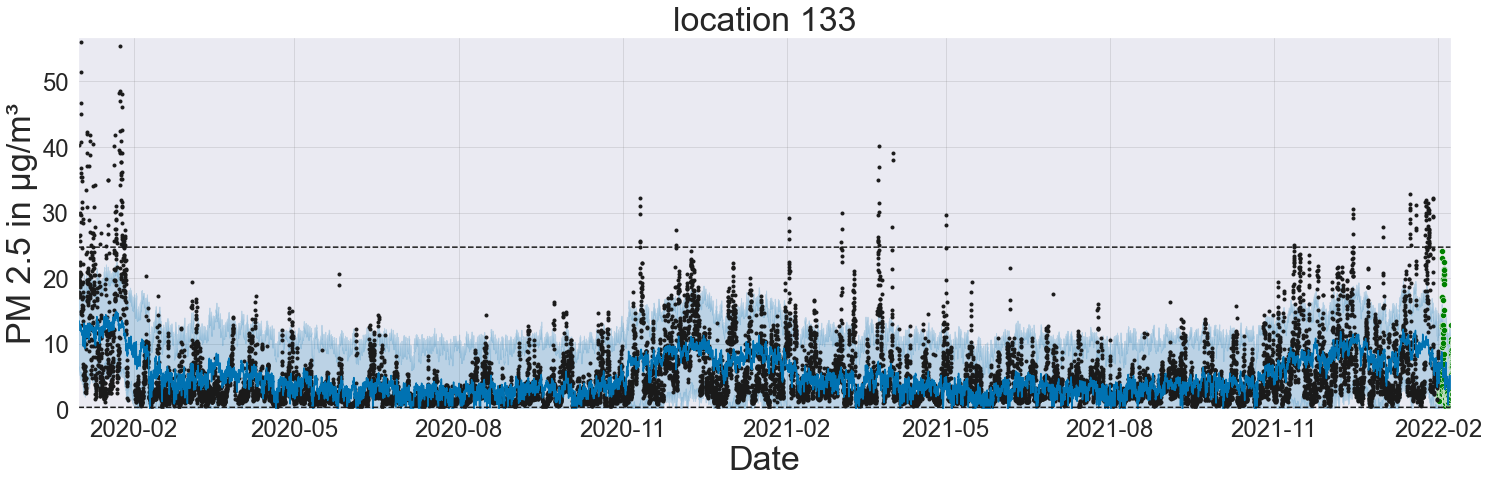

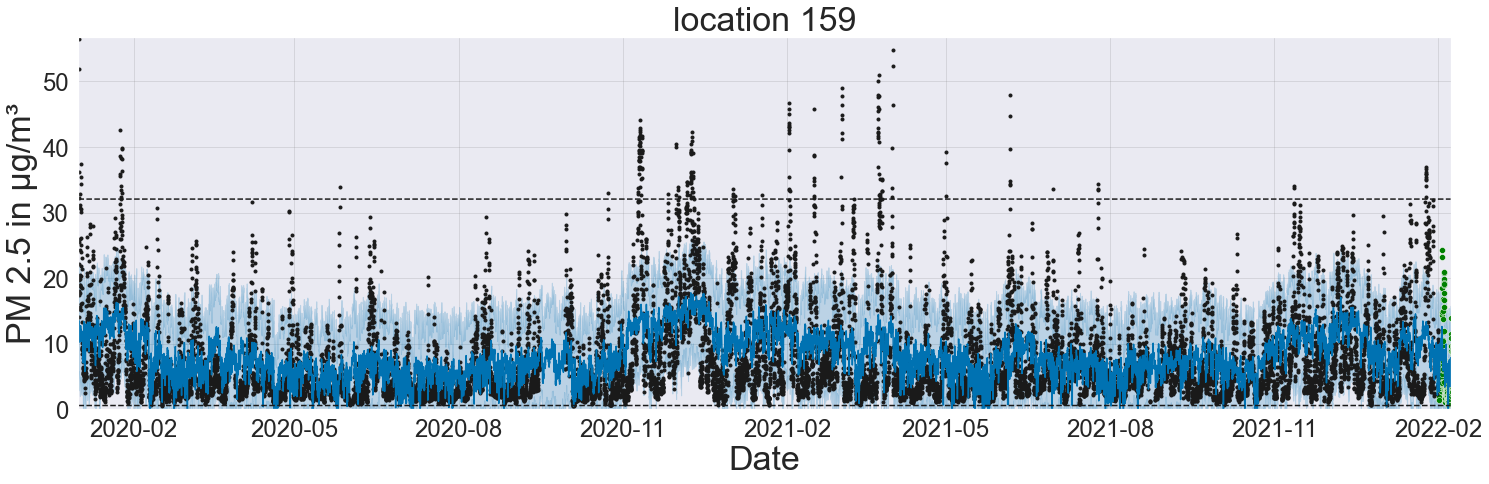

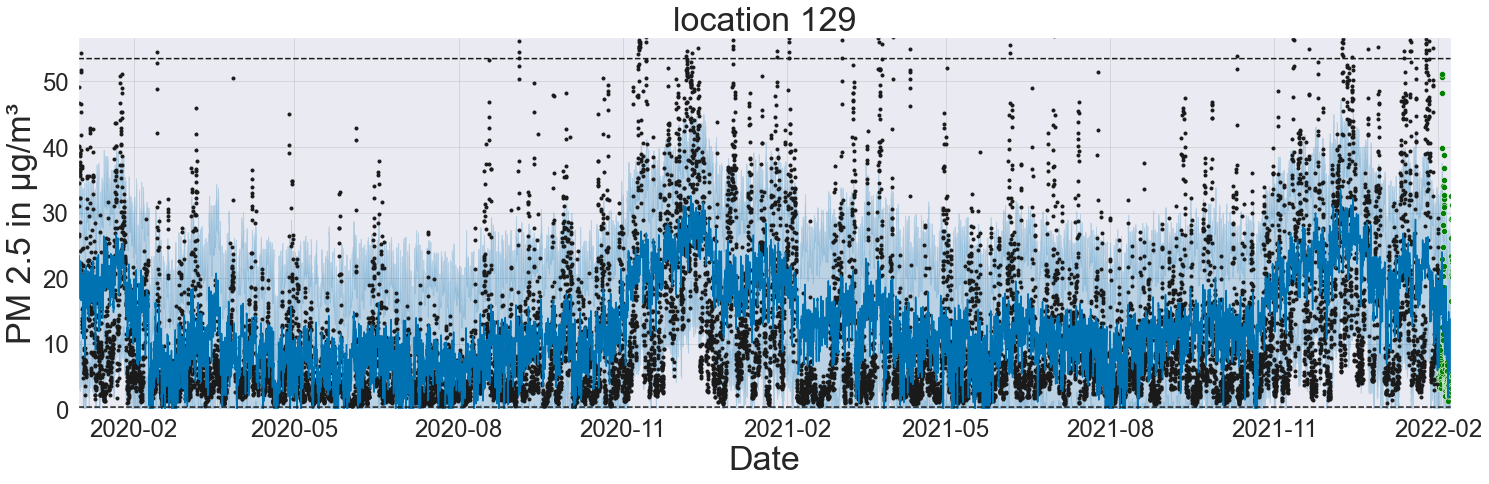

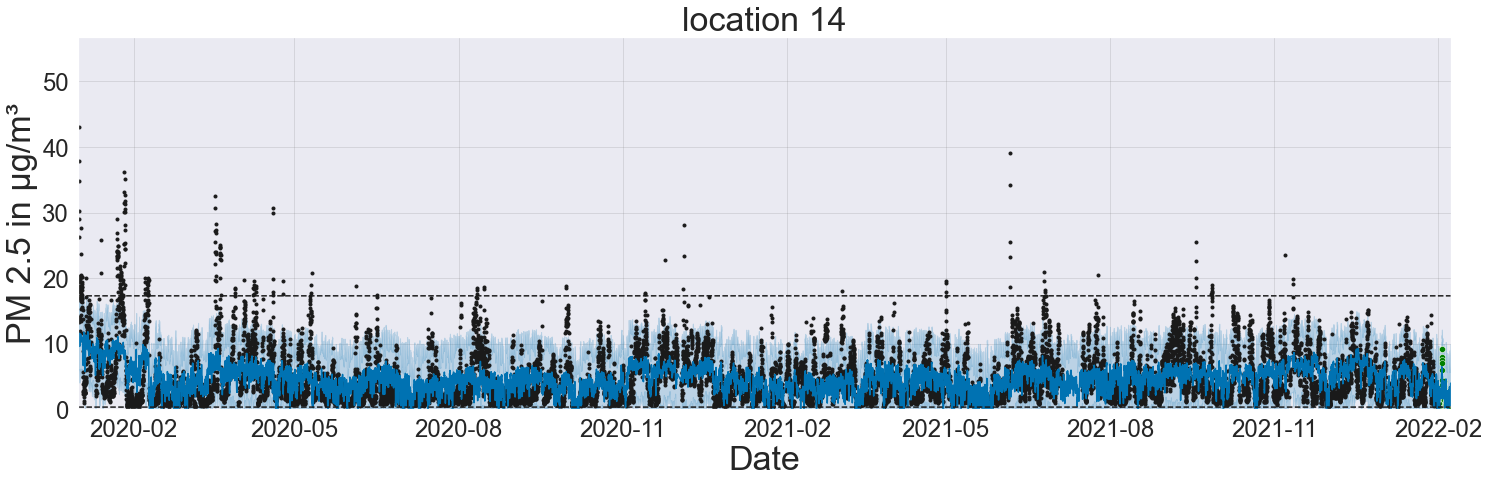

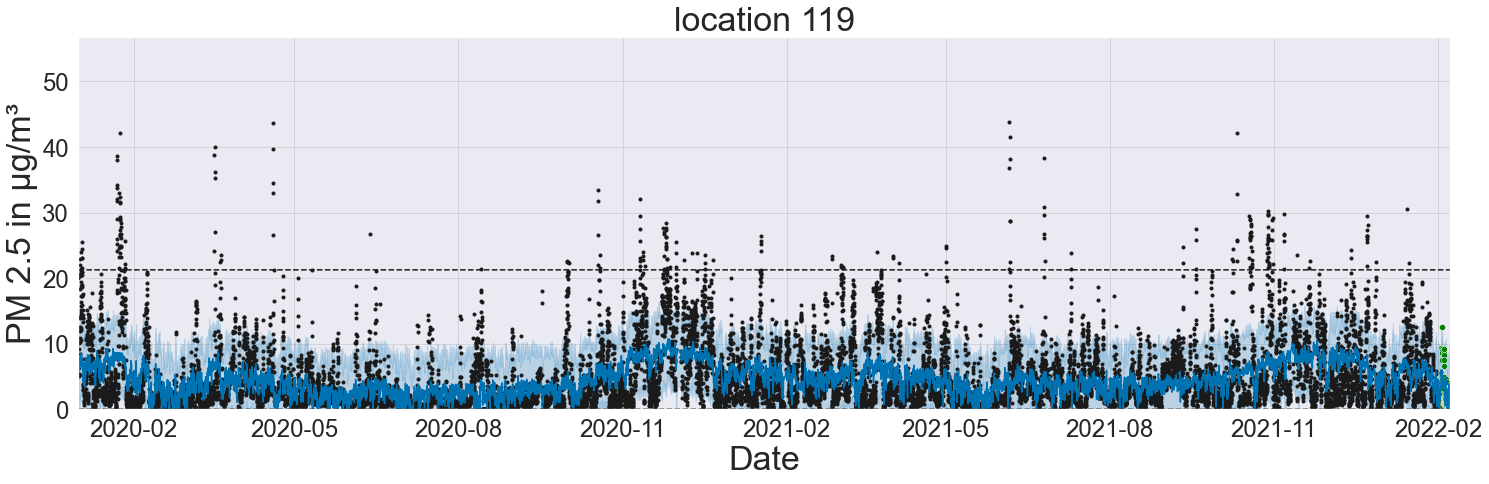

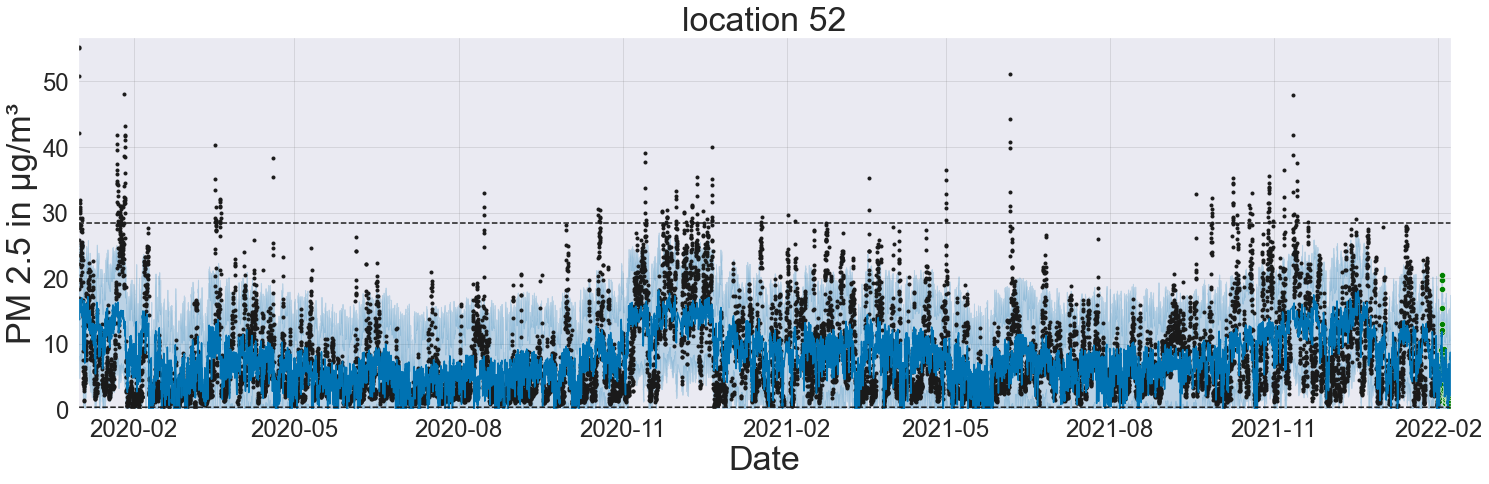

In [10]:
# plot models
for location_id in location_list_reg[:NUMBER_OF_MODELS_REG]:
    model_reg = prophet_models_per_location_reg[location_id]
    # limit test data to current location
    df_test_location = df_test_data[df_test_data['location_id'] == location_id]
    plot_model_with_future(model_reg, prophet_forecasts_per_location_reg[location_id], df_test_location, f'../images/prophet_reg_location_id_{run_name}_{location_id}.png')

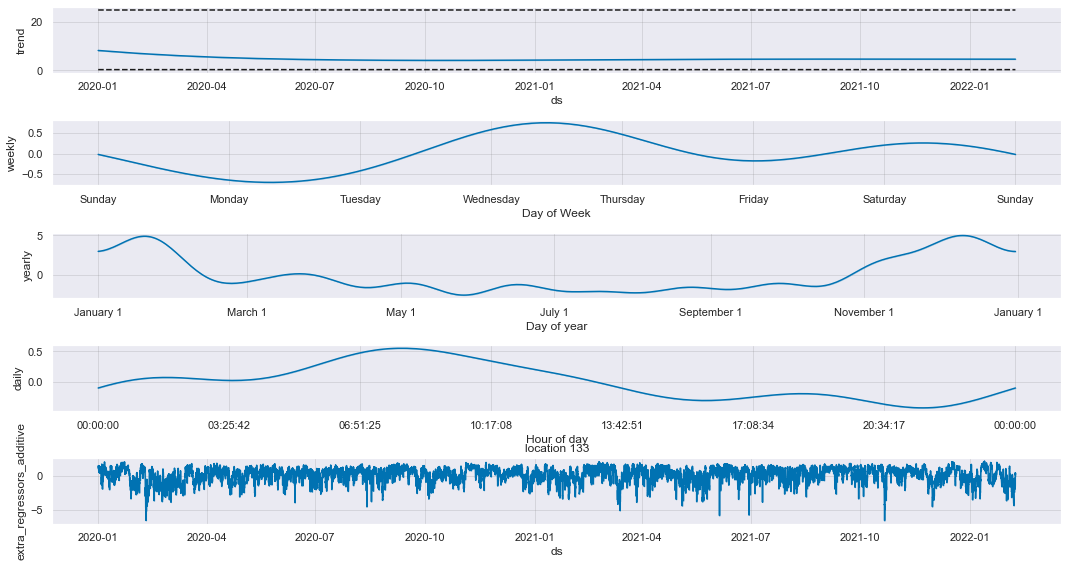

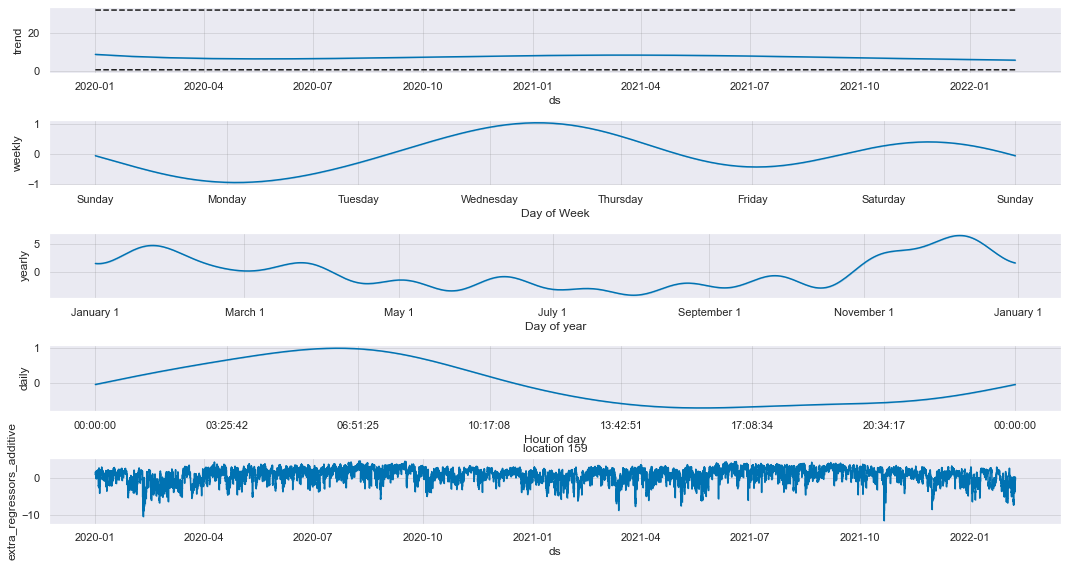

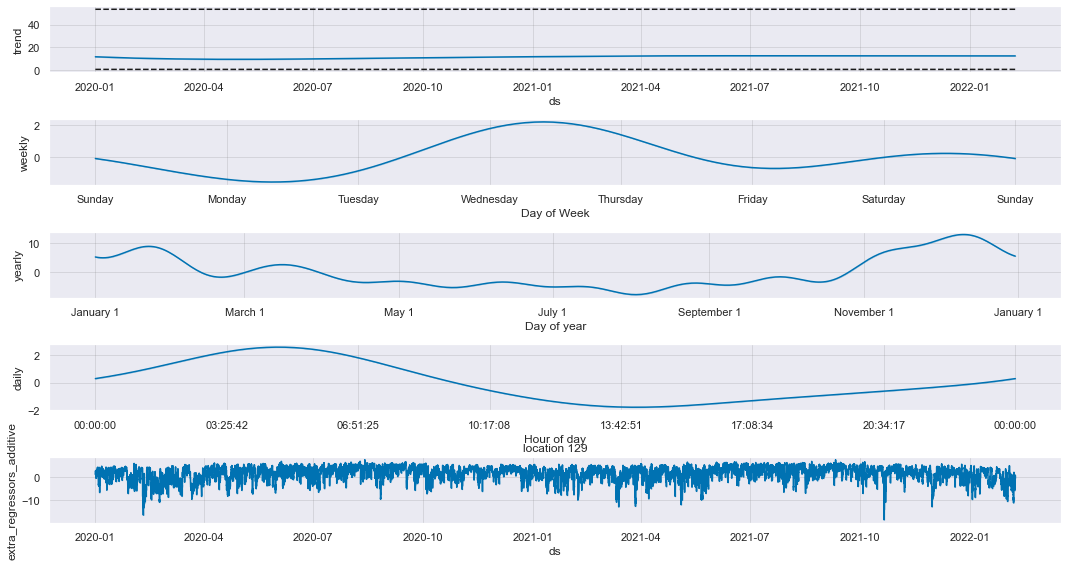

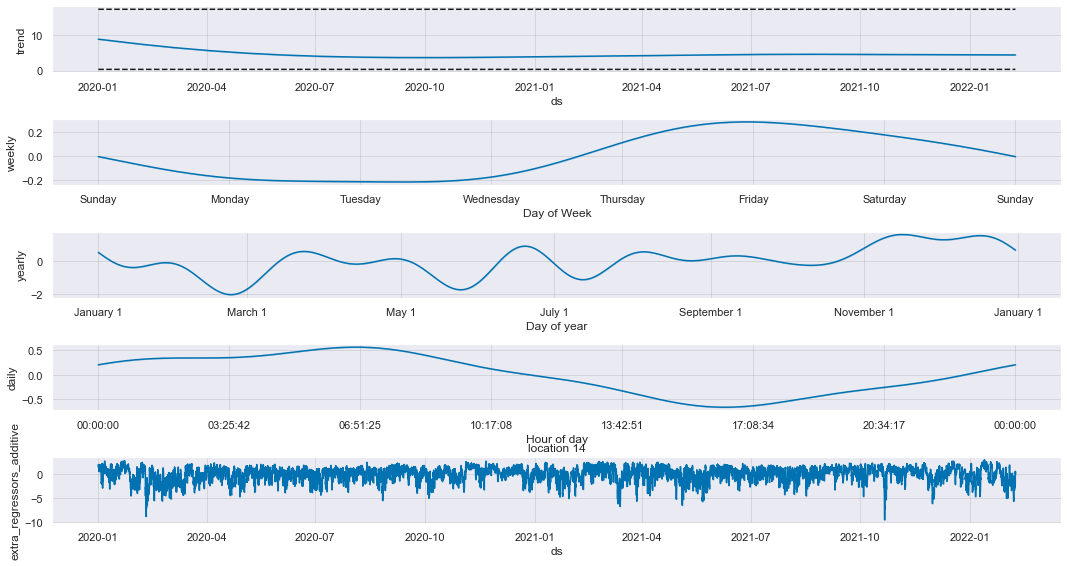

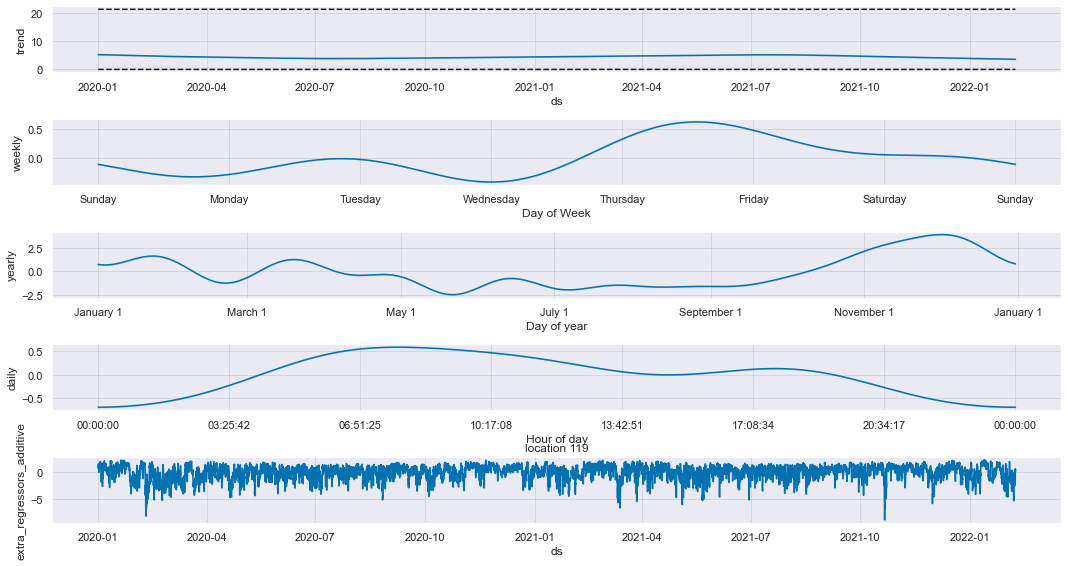

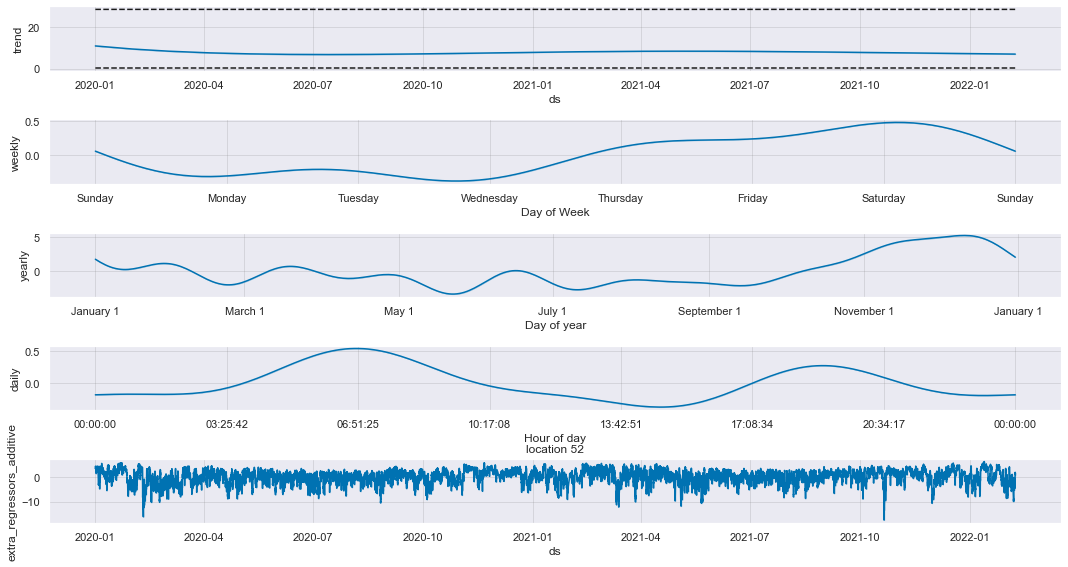

In [11]:
# plot components of models
for location_id in location_list_reg[:NUMBER_OF_MODELS_REG]:
    model_reg = prophet_models_per_location_reg[location_id]
    fig2 = model_reg.plot_components(prophet_forecasts_per_location_reg[location_id], figsize=(15, 8))
    plt.title(f'location {location_id}')

    fig2.savefig(f'../images/prophet_components_reg_location_id_{run_name}_{location_id}.png', bbox_inches='tight', facecolor="#EEEEEE")